In [7]:
import json
import logging
import pickle
import re
import string
from datetime import datetime
from pathlib import Path

import gensim
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from gensim import corpora, models
from gensim.models import CoherenceModel
from gsdmm import MovieGroupProcess
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
from unidecode import unidecode
from ydata_profiling import ProfileReport

%matplotlib inline

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\milto\AppData\Local\Temp/ipykernel_20740/878591297.py:16 in <module>                    │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\milto\\AppData\\Local\\Temp/ipykernel_20740/878591297.py'                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ModuleNotFoundError: No module named 'gsdmm'

In [8]:
!pip install fast-gsdmm

In [180]:
tweets_df = pd.read_pickle("all_tweets_v9.pkl")
users_df = pd.read_excel("HRA Twitter Accounts.xlsx")
users_df = users_df[users_df.valid == 1]

/var/folders/z5/hjyvlbm54v1cpt9s019vbv9w0000gn/T/ipykernel_31070/3826930059.py:2: FutureWarning: Inferring datetime64[ns, UTC] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns, UTC])
  users_df = pd.read_excel("HRA Twitter Accounts.xlsx")


In [3]:
tweets_df.head()

author_id context_annotations      conversation_id  \
0  1449804331142811655                 NaN  1617597872803041280   
1  1449804331142811655                 NaN  1617597646339702823   
2  1449804331142811655                 NaN  1617597571903676417   
3  1449804331142811655                 NaN  1617597543000440844   
4  1449804331142811655                 NaN  1617597477963829248   

                  created_at edit_history_tweet_ids                   id  \
0  2023-01-23 18:59:21+00:00  [1617597872803041280]  1617597872803041280   
1  2023-01-23 18:58:27+00:00  [1617597646339702823]  1617597646339702823   
2  2023-01-23 18:58:09+00:00  [1617597571903676417]  1617597571903676417   
3  2023-01-23 18:58:02+00:00  [1617597543000440844]  1617597543000440844   
4  2023-01-23 18:57:46+00:00  [1617597477963829248]  1617597477963829248   

   in_reply_to_user_id lang  possibly_sensitive  \
0                  NaN   tr               False   
1                  NaN  qme               False   
2                  NaN   tr               False   
3                  NaN  qme               False   
4                  NaN   tr               False   

                                   referenced_tweets reply_settings  \
0                                                NaN       everyone   
1                                                NaN       everyone   
2  [<ReferencedTweet id=1617584897383714816 type=...       everyone   
3                                                NaN       everyone   
4  [<ReferencedTweet id=1617597368417013761 type=...       everyone   

                                                text      author withheld  \
0  Kararlarındaki temel dayanak, hukukun evrensel...  Goksun_KHK      NaN   
1  #OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU  Goksun_KHK      NaN   
2  RT @Yozgat_KHK: #OhalKomisyonuHukuksuzdur\nÇün...  Goksun_KHK      NaN   
3  #OhalKomisyonuHukuksuzdur https://t.co/FHdc5DQ0u0  Goksun_KHK      NaN   
4  RT @Malatya_KHK: Öldükten sonra insanlari işe ...  Goksun_KHK      NaN   

   geo  quote_count  retweet_count  like_count  reply_count  impression_count  \
0  NaN            0              2           1            0                82   
1  NaN            0              1           0            0                52   
2  NaN            0             48           0            0                 0   
3  NaN            1              1           1            0                86   
4  NaN            0              4           0            0                 0   

                  media_keys poll_ids  \
0                        NaN      NaN   
1  ['3_1617597636604723228']      NaN   
2                        NaN      NaN   
3  ['3_1617597534494392354']      NaN   
4                        NaN      NaN   

                                            hashtags  \
0  [{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...   
1  [{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...   
2  [{'start': 16, 'end': 41, 'tag': 'OhalKomisyon...   
3  [{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...   
4  [{'start': 57, 'end': 82, 'tag': 'OhalKomisyon...   

                                                urls  \
0                                                NaN   
1  [{'start': 26, 'end': 49, 'url': 'https://t.co...   
2                                                NaN   
3  [{'start': 26, 'end': 49, 'url': 'https://t.co...   
4                                                NaN   

                                            mentions cashtags annotations  \
0                                                NaN      NaN         NaN   
1                                                NaN      NaN         NaN   
2  [{'start': 3, 'end': 14, 'username': 'Yozgat_K...      NaN         NaN   
3                                                NaN      NaN         NaN   
4  [{'start': 3, 'end': 15, 'username': 'Malatya_...      NaN         NaN   

   is_retweet  
0       False  
1       False  
2        True  
3       False  
4    

In [4]:
relevant_columns = [
    "created_at",
    "in_reply_to_user_id",
    "lang",
    "possibly_sensitive",
    "reply_settings",
    "author",
    "withheld",
    "geo",
    "quote_count",
    "retweet_count",
    "like_count",
    "reply_count",
    "impression_count",
    "media_keys",
    "poll_ids",
    "hashtags",
    "urls",
    "mentions",
    "cashtags",
    "annotations",
    "is_retweet",
]

In [5]:
users_df.head()

full_name      screen_name method_to_find comment  valid  \
0       Akın Birdal      akin_birdal     web-search     NaN      1   
2       Cemil Çiçek     avcemilcicek     well-known     NaN      1   
4  Ayşe Gül Altınay      aysealtinay     web-search     NaN      1   
5    Basak Demirtas  Basak__Demirtas     well-known     NaN      1   
7     Nurcan Baysal    baysal_nurcan     web-search     NaN      1   

                      location              name                created_at  \
0                          NaN       Akın Birdal 2013-04-14 16:39:04+00:00   
2              Çankaya, Ankara       Cemil Çiçek 2011-07-20 11:49:01+00:00   
4                    Istanbul   Ayşe Gül Altınay 2010-11-28 23:09:32+00:00   
5          Diyarbakır, Türkiye    Başak Demirtaş 2018-04-26 15:32:01+00:00   
7  Diyarbakır/İstanbul/Türkiye     Nurcan Baysal 2013-02-05 20:02:36+00:00   

                                         description verified  \
0                                                NaN    False   
2  Hukukçu/Law - @ASBUedu Asian Studies MA | Ceza...    False   
4                                                NaN    False   
5                  İnsan, öğretmen, evlat, eş, anne.     True   
7  Author, journalist, human rights defender,part...    False   

   followers_count  following_count  tweet_count            id  
0          80216.0            786.0       2937.0  1.352279e+09  
2         112011.0           1361.0      14618.0  3.389775e+08  
4           6883.0           2519.0      10187.0  2.208243e+08  
5         403073.0            197.0       1265.0  9.895275e+17  
7         154920.0           1846.0      49568.0  1.151887e+09

In [135]:
profile = ProfileReport(tweets_df[relevant_columns], title="Profiling Report")
profile.to_widgets()
profile.to_notebook_iframe()

/Users/hasansalimkanmaz/environments/master-thesis/lib/python3.10/site-packages/ydata_profiling/utils/dataframe.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"index": "df_index"}, inplace=True)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/hasansalimkanmaz/environments/master-thesis/lib/python3.10/site-packages/ydata_profiling/model/correlations.py:67: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'No data; `observed` has size 0.')
  warnings.warn(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
profile = ProfileReport(users_df, title="Profiling Report")
profile.to_widgets()
profile.to_notebook_iframe()

Render widgets:   0%|                                                                                                                                                                                             | 0/1 [00:00<?, ?it/s]

Render HTML: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


# Investigate created_at column of tweets-df

In [44]:
tweets_df.created_at = pd.to_datetime(
    tweets_df.created_at, format="%Y-%m-%d %H:%M:%S+00:00"
)

In [45]:
tweets_df["created_at_date"] = pd.to_datetime(tweets_df.created_at.dt.date)

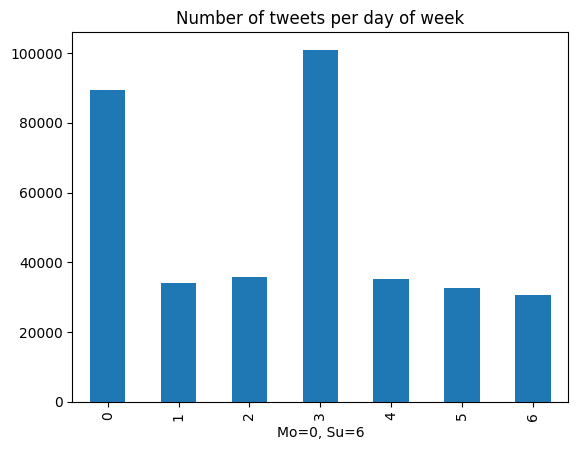

In [104]:
tweets_df.created_at_date.groupby(tweets_df.created_at_date.dt.dayofweek).count().plot(
    kind="bar"
)
plt.title("Number of tweets per day of week")
plt.xlabel("Mo=0, Su=6")
plt.show()

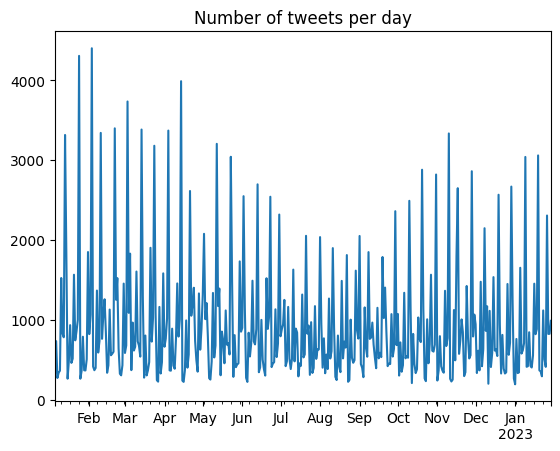

In [102]:
tweets_df.created_at_date.groupby(tweets_df.created_at_date).count().plot()
plt.title("Number of tweets per day")
plt.xlabel("")
plt.show()

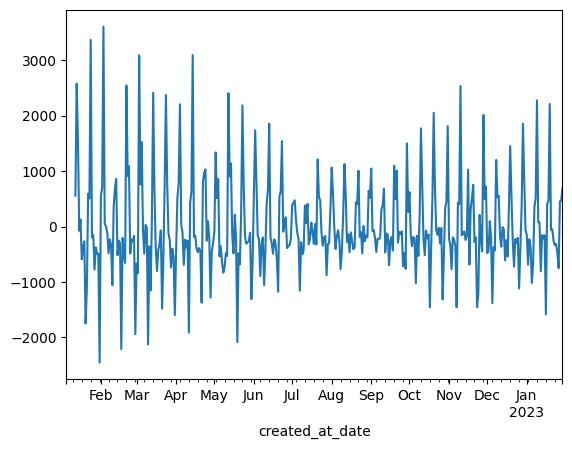

In [111]:
count_per_day_df = tweets_df.created_at_date.groupby(tweets_df.created_at_date).count()
count_per_day_df.diff(7).plot()
plt.show()

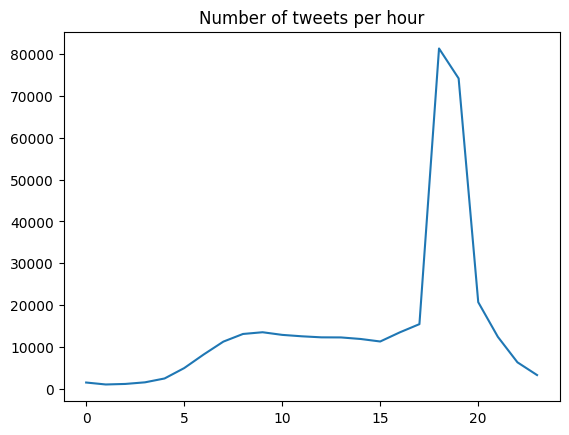

In [105]:
count_per_hour_df = tweets_df.created_at.groupby(tweets_df.created_at.dt.hour).count()
count_per_hour_df.plot()
plt.title("Number of tweets per hour")
plt.xlabel("")
plt.show()

In [107]:
only_tweets_df = tweets_df[~tweets_df.is_retweet]

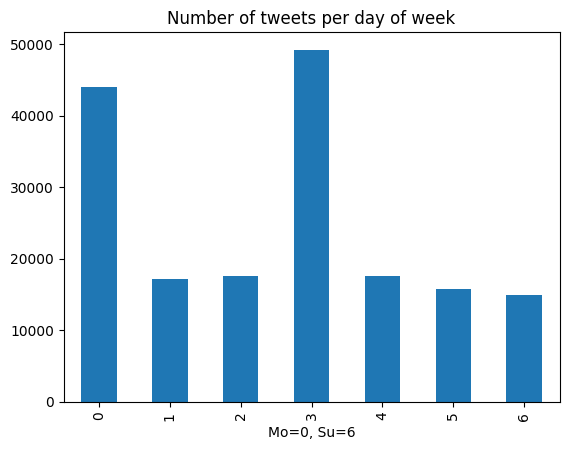

In [110]:
only_tweets_df.created_at_date.groupby(
    only_tweets_df.created_at_date.dt.dayofweek
).count().plot(kind="bar")
plt.title("Number of tweets per day of week")
plt.xlabel("Mo=0, Su=6")
plt.show()

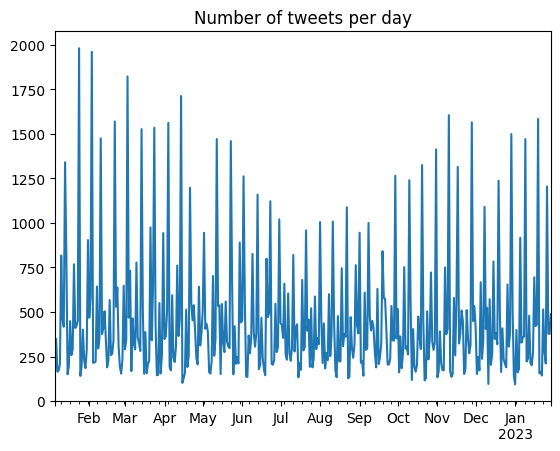

In [109]:
# plt.figure(figsize=(50, 50))
only_tweets_df.created_at_date.groupby(only_tweets_df.created_at_date).count().plot()
plt.title("Number of tweets per day")
plt.xlabel("")
plt.show()

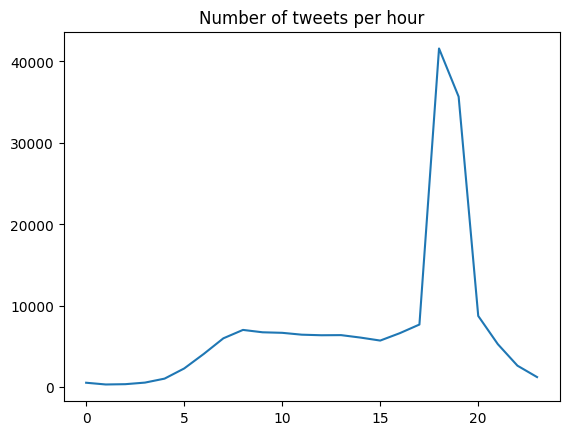

In [108]:
count_per_hour_df = only_tweets_df.created_at.groupby(
    only_tweets_df.created_at.dt.hour
).count()
count_per_hour_df.plot()
plt.title("Number of tweets per hour")
plt.xlabel("")
plt.show()

# Investigate account types with tweets

In [112]:
users_df.head()

full_name      screen_name method_to_find comment  valid  \
0       Akın Birdal      akin_birdal     web-search     NaN      1   
2       Cemil Çiçek     avcemilcicek     well-known     NaN      1   
4  Ayşe Gül Altınay      aysealtinay     web-search     NaN      1   
5    Basak Demirtas  Basak__Demirtas     well-known     NaN      1   
7     Nurcan Baysal    baysal_nurcan     web-search     NaN      1   

                      location              name                created_at  \
0                          NaN       Akın Birdal 2013-04-14 16:39:04+00:00   
2              Çankaya, Ankara       Cemil Çiçek 2011-07-20 11:49:01+00:00   
4                    Istanbul   Ayşe Gül Altınay 2010-11-28 23:09:32+00:00   
5          Diyarbakır, Türkiye    Başak Demirtaş 2018-04-26 15:32:01+00:00   
7  Diyarbakır/İstanbul/Türkiye     Nurcan Baysal 2013-02-05 20:02:36+00:00   

                                         description verified  \
0                                                NaN    False   
2  Hukukçu/Law - @ASBUedu Asian Studies MA | Ceza...    False   
4                                                NaN    False   
5                  İnsan, öğretmen, evlat, eş, anne.     True   
7  Author, journalist, human rights defender,part...    False   

   followers_count  following_count  tweet_count            id  
0          80216.0            786.0       2937.0  1.352279e+09  
2         112011.0           1361.0      14618.0  3.389775e+08  
4           6883.0           2519.0      10187.0  2.208243e+08  
5         403073.0            197.0       1265.0  9.895275e+17  
7         154920.0           1846.0      49568.0  1.151887e+09

In [120]:
tweets_df_with_method_to_find = tweets_df.merge(
    users_df[["screen_name", "method_to_find"]],
    left_on="author",
    right_on="screen_name",
)

In [121]:
tweets_df_with_method_to_find.head()

author_id context_annotations      conversation_id  \
0  1449804331142811655                 NaN  1617597872803041280   
1  1449804331142811655                 NaN  1617597646339702823   
2  1449804331142811655                 NaN  1617597571903676417   
3  1449804331142811655                 NaN  1617597543000440844   
4  1449804331142811655                 NaN  1617597477963829248   

           created_at edit_history_tweet_ids                   id  \
0 2023-01-23 18:59:21  [1617597872803041280]  1617597872803041280   
1 2023-01-23 18:58:27  [1617597646339702823]  1617597646339702823   
2 2023-01-23 18:58:09  [1617597571903676417]  1617597571903676417   
3 2023-01-23 18:58:02  [1617597543000440844]  1617597543000440844   
4 2023-01-23 18:57:46  [1617597477963829248]  1617597477963829248   

   in_reply_to_user_id lang  possibly_sensitive  \
0                  NaN   tr               False   
1                  NaN  qme               False   
2                  NaN   tr               False   
3                  NaN  qme               False   
4                  NaN   tr               False   

                                   referenced_tweets reply_settings  \
0                                                NaN       everyone   
1                                                NaN       everyone   
2  [<ReferencedTweet id=1617584897383714816 type=...       everyone   
3                                                NaN       everyone   
4  [<ReferencedTweet id=1617597368417013761 type=...       everyone   

                                                text      author withheld  \
0  Kararlarındaki temel dayanak, hukukun evrensel...  Goksun_KHK      NaN   
1  #OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU  Goksun_KHK      NaN   
2  RT @Yozgat_KHK: #OhalKomisyonuHukuksuzdur\nÇün...  Goksun_KHK      NaN   
3  #OhalKomisyonuHukuksuzdur https://t.co/FHdc5DQ0u0  Goksun_KHK      NaN   
4  RT @Malatya_KHK: Öldükten sonra insanlari işe ...  Goksun_KHK      NaN   

   geo  quote_count  retweet_count  like_count  reply_count  impression_count  \
0  NaN            0              2           1            0                82   
1  NaN            0              1           0            0                52   
2  NaN            0             48           0            0                 0   
3  NaN            1              1           1            0                86   
4  NaN            0              4           0            0                 0   

                  media_keys poll_ids  \
0                        NaN      NaN   
1  ['3_1617597636604723228']      NaN   
2                        NaN      NaN   
3  ['3_1617597534494392354']      NaN   
4                        NaN      NaN   

                                            hashtags  \
0  [{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...   
1  [{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...   
2  [{'start': 16, 'end': 41, 'tag': 'OhalKomisyon...   
3  [{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...   
4  [{'start': 57, 'end': 82, 'tag': 'OhalKomisyon...   

                                                urls  \
0                                                NaN   
1  [{'start': 26, 'end': 49, 'url': 'https://t.co...   
2                                                NaN   
3  [{'start': 26, 'end': 49, 'url': 'https://t.co...   
4                                                NaN   

                                            mentions cashtags annotations  \
0                                                NaN      NaN         NaN   
1                                                NaN      NaN         NaN   
2  [{'start': 3, 'end': 14, 'username': 'Yozgat_K...      NaN         NaN   
3                                                NaN      NaN         NaN   
4  [{'start': 3, 'end': 15, 'username': 'Malatya_...      NaN         NaN   

   is_retweet created_at_date screen_name        method_to_find  
0       False      2023-01-23  Goksun_KHK  keyword search - k

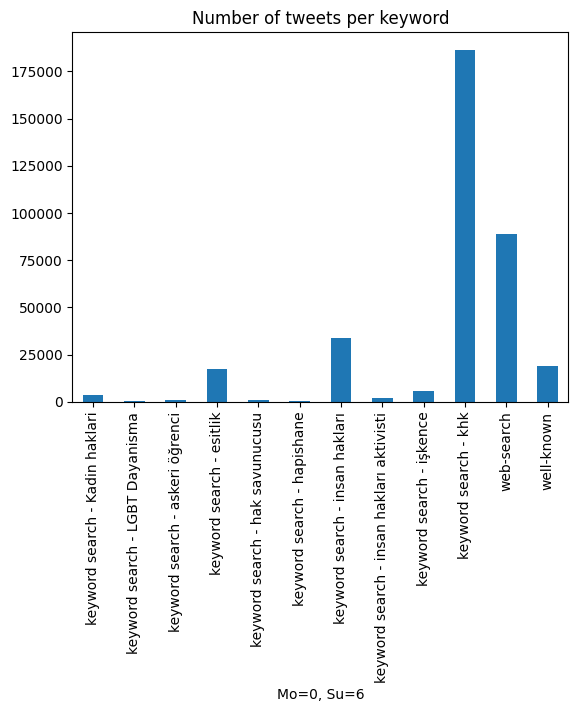

In [126]:
tweets_df_with_method_to_find.created_at_date.groupby(
    tweets_df_with_method_to_find.method_to_find
).count().plot(kind="bar")
plt.title("Number of tweets per keyword")
plt.xlabel("Mo=0, Su=6")
plt.show()

In [127]:
tweets_df_without_khk = tweets_df_with_method_to_find[
    tweets_df_with_method_to_find.method_to_find != "keyword search - khk"
]

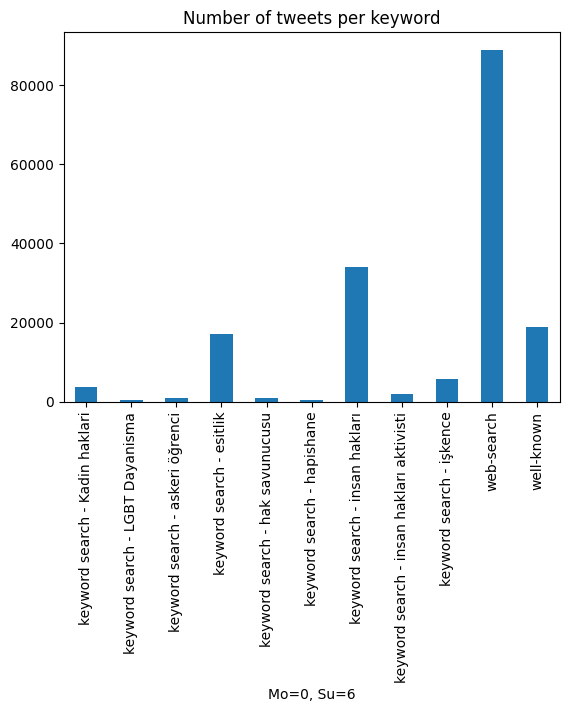

In [128]:
tweets_df_without_khk.created_at_date.groupby(
    tweets_df_without_khk.method_to_find
).count().plot(kind="bar")
plt.title("Number of tweets per keyword")
plt.xlabel("Mo=0, Su=6")
plt.show()

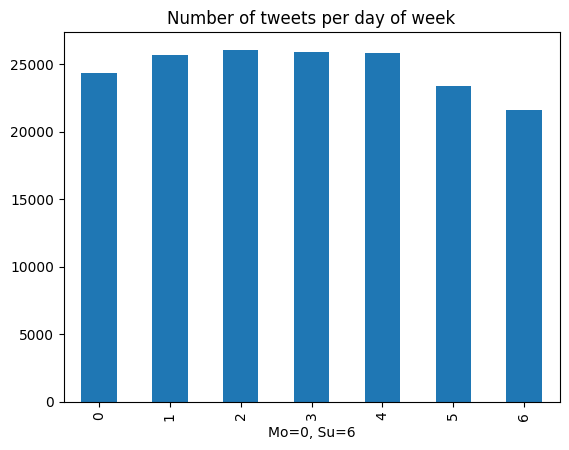

In [129]:
tweets_df_without_khk.created_at_date.groupby(
    tweets_df_without_khk.created_at_date.dt.dayofweek
).count().plot(kind="bar")
plt.title("Number of tweets per day of week")
plt.xlabel("Mo=0, Su=6")
plt.show()

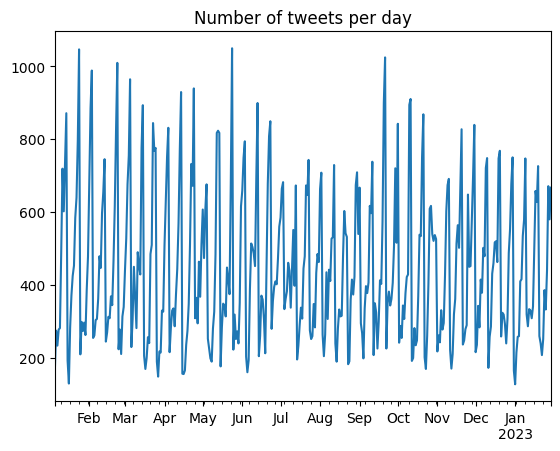

In [130]:
tweets_df_without_khk.created_at_date.groupby(
    tweets_df_without_khk.created_at_date
).count().plot()
plt.title("Number of tweets per day")
plt.xlabel("")
plt.show()

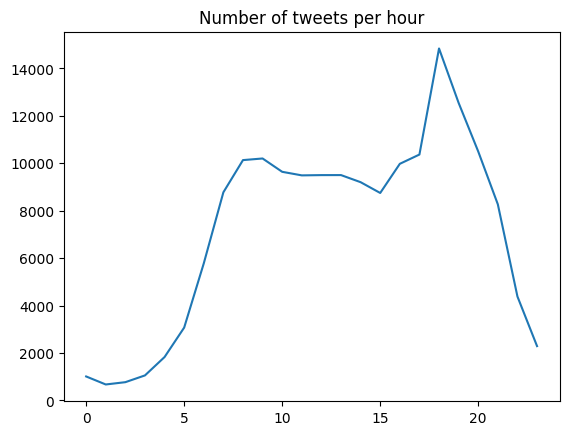

In [132]:
tweets_df_without_khk.created_at.groupby(
    tweets_df_without_khk.created_at.dt.hour
).count().plot()
plt.title("Number of tweets per hour")
plt.xlabel("")
plt.show()

# Investigate reply tweets

In [133]:
tweets_df.head()

author_id context_annotations      conversation_id  \
0  1449804331142811655                 NaN  1617597872803041280   
1  1449804331142811655                 NaN  1617597646339702823   
2  1449804331142811655                 NaN  1617597571903676417   
3  1449804331142811655                 NaN  1617597543000440844   
4  1449804331142811655                 NaN  1617597477963829248   

           created_at edit_history_tweet_ids                   id  \
0 2023-01-23 18:59:21  [1617597872803041280]  1617597872803041280   
1 2023-01-23 18:58:27  [1617597646339702823]  1617597646339702823   
2 2023-01-23 18:58:09  [1617597571903676417]  1617597571903676417   
3 2023-01-23 18:58:02  [1617597543000440844]  1617597543000440844   
4 2023-01-23 18:57:46  [1617597477963829248]  1617597477963829248   

   in_reply_to_user_id lang  possibly_sensitive  \
0                  NaN   tr               False   
1                  NaN  qme               False   
2                  NaN   tr               False   
3                  NaN  qme               False   
4                  NaN   tr               False   

                                   referenced_tweets reply_settings  \
0                                                NaN       everyone   
1                                                NaN       everyone   
2  [<ReferencedTweet id=1617584897383714816 type=...       everyone   
3                                                NaN       everyone   
4  [<ReferencedTweet id=1617597368417013761 type=...       everyone   

                                                text      author withheld  \
0  Kararlarındaki temel dayanak, hukukun evrensel...  Goksun_KHK      NaN   
1  #OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU  Goksun_KHK      NaN   
2  RT @Yozgat_KHK: #OhalKomisyonuHukuksuzdur\nÇün...  Goksun_KHK      NaN   
3  #OhalKomisyonuHukuksuzdur https://t.co/FHdc5DQ0u0  Goksun_KHK      NaN   
4  RT @Malatya_KHK: Öldükten sonra insanlari işe ...  Goksun_KHK      NaN   

   geo  quote_count  retweet_count  like_count  reply_count  impression_count  \
0  NaN            0              2           1            0                82   
1  NaN            0              1           0            0                52   
2  NaN            0             48           0            0                 0   
3  NaN            1              1           1            0                86   
4  NaN            0              4           0            0                 0   

                  media_keys poll_ids  \
0                        NaN      NaN   
1  ['3_1617597636604723228']      NaN   
2                        NaN      NaN   
3  ['3_1617597534494392354']      NaN   
4                        NaN      NaN   

                                            hashtags  \
0  [{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...   
1  [{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...   
2  [{'start': 16, 'end': 41, 'tag': 'OhalKomisyon...   
3  [{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...   
4  [{'start': 57, 'end': 82, 'tag': 'OhalKomisyon...   

                                                urls  \
0                                                NaN   
1  [{'start': 26, 'end': 49, 'url': 'https://t.co...   
2                                                NaN   
3  [{'start': 26, 'end': 49, 'url': 'https://t.co...   
4                                                NaN   

                                            mentions cashtags annotations  \
0                                                NaN      NaN         NaN   
1                                                NaN      NaN         NaN   
2  [{'start': 3, 'end': 14, 'username': 'Yozgat_K...      NaN         NaN   
3                                                NaN      NaN         NaN   
4  [{'start': 3, 'end': 15, 'username': 'Malatya_...      NaN         NaN   

   is_retweet created_at_date  
0       False      2023-01-23  
1       False      2023-01-23  
2        True      2023-01-23  

In [143]:
tweets_df[~tweets_df.in_reply_to_user_id.isna()].shape[0] / tweets_df.shape[0]

0.13987455296961865

# Investigate qme tweets

In [173]:
tweets_df[["like_count", "retweet_count"]].groupby(
    tweets_df.lang.isin(["qme", "qht", "zxx"])
).count()

like_count  retweet_count
lang                            
False      349530         349530
True         9506           9506

In [174]:
9500 / 350000

0.027142857142857142

# Investigate language 

In [145]:
tweets_df.lang.value_counts()

tr     327488
en      14048
qme      4646
qht      3074
und      2729
zxx      1786
ro        803
fr        798
de        522
in        465
qam       366
et        246
cy        185
art       174
pt        164
es        157
sv        149
fi        142
ckb       126
ht         96
nl         79
lt         68
it         66
tl         64
eu         61
qst        61
hu         53
el         51
fa         46
ar         43
hi         40
is         37
ca         31
lv         29
da         22
cs         18
no         16
zh         13
vi         13
sl         13
ja         12
pl         10
ru         10
uk          7
hy          4
iw          4
ug          1
Name: lang, dtype: int64

In [180]:
for i in tweets_df[tweets_df.lang == "iw"].text.head(100):
    print(i)
    print("\n\n")

Bu sabah Harkov Bölge İdare binasına saldırı düzenlendi. Ölü ve yaralılar var
#SavaşaHayır

הבוקר הותקף בניין מינהל האזורי בחרקוב: בתקיפה נפצעו 6 בני אדם, בהם ילד אחד. בנוסף ישנם מספר הרוגים במקום. בשעה זו כוחות ההצלה פועלים לחילוץ וחיפוש לכודים וניצולים נוספים. https://t.co/OlLBcxcpAF



אזרחי ישראל
כפי שאתם, מסיבות מוצדקות לחלוטין טוענים בפני העולם שאין לסמוך על איראן, אני טוען בפניכם, שאסור לסמוך על הדיקטטור ארדואן ושלטונו, בסופו של יום ובהתאם לאינטרסים שלו, הוא לא יהסס לדקור אתכם בגב! @RTErdogan https://t.co/5U9ET8SfFZ



RT @thesportsrabbi: אנס קאנטר: "זה מאוד מרגש לראות מוסלמים משחקים עם יהודים ויהודים עם נוצרים" - מאת @mobluelion
@EnesFreedom
https://t.co/…



RT @DREDYCOHEN: תכירו את ערוץ כאן 33 הערוץ הפלשתיני שאנחנו משלמים עבורו. על רקע החלטת בן גביר למנוע הנפת הדגל הפלש' במקומות ציבוריים החליטו…





# Investigate possibly_sensitive column

In [182]:
tweets_df.possibly_sensitive.value_counts()

False    357255
True       1781
Name: possibly_sensitive, dtype: int64

In [188]:
tweets_df.groupby(tweets_df.possibly_sensitive).mean()[["retweet_count", "like_count"]]

/var/folders/z5/hjyvlbm54v1cpt9s019vbv9w0000gn/T/ipykernel_27184/1652493715.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tweets_df.groupby(tweets_df.possibly_sensitive).mean()[["retweet_count", "like_count"]]


retweet_count  like_count
possibly_sensitive                           
False                  140.209873   64.029925
True                   259.373947   49.908478

# Investigate referenced tweets

In [197]:
tweets_df[~tweets_df.referenced_tweets.isna()].shape[0] / tweets_df.shape[0]

0.7462594280239307

In [199]:
tweets_df[
    (~tweets_df.referenced_tweets.isna()) & (tweets_df.is_retweet == False)
].head()

author_id context_annotations      conversation_id  \
311  1449804331142811655                 NaN  1526275197745127424   
312  1449804331142811655                 NaN  1526275197745127424   
471  1449804331142811655                 NaN  1500900491466842122   
504  1449804331142811655                 NaN  1495830706630582275   
505  1449804331142811655                 NaN  1495825675529465858   

             created_at edit_history_tweet_ids                   id  \
311 2022-05-17 07:56:04  [1526471597627940865]  1526471597627940865   
312 2022-05-17 07:54:31  [1526471210443366401]  1526471210443366401   
471 2022-03-07 18:25:37  [1500900491466842122]  1500900491466842122   
504 2022-02-21 18:40:06  [1495830706630582275]  1495830706630582275   
505 2022-02-21 18:20:06  [1495825675529465858]  1495825675529465858   

     in_reply_to_user_id lang  possibly_sensitive  \
311         1.237056e+18   tr               False   
312         1.237056e+18   tr               False   
471                  NaN   tr               False   
504                  NaN   tr               False   
505                  NaN   tr               False   

                                     referenced_tweets reply_settings  \
311  [<ReferencedTweet id=1526275197745127424 type=...       everyone   
312  [<ReferencedTweet id=1526275197745127424 type=...       everyone   
471  [<ReferencedTweet id=1500895277175218177 type=...       everyone   
504  [<ReferencedTweet id=1495827553906569221 type=...       everyone   
505  [<ReferencedTweet id=1495821507355947013 type=...       everyone   

                                                  text      author withheld  \
311  @devapartisi @devapartisi\n@KmarasaDEVA\n#KHKE...  Goksun_KHK      NaN   
312  @devapartisi @devapartisi\n@KmarasaDEVA\n#KHKE...  Goksun_KHK      NaN   
471  #YaşamakDirenmektir her durumda https://t.co/h...  Goksun_KHK      NaN   
504        KHKlıda GeççekDiyor https://t.co/seACKV185a  Goksun_KHK      NaN   
505        KHKlıda GeççekDiyor https://t.co/QbxDSzLaVe  Goksun_KHK      NaN   

     geo  quote_count  retweet_count  like_count  reply_count  \
311  NaN            1             18          23            0   
312  NaN            0              1           2            0   
471  NaN            0              0           2            0   
504  NaN            0              0           0            0   
505  NaN            0              0           0            0   

     impression_count media_keys poll_ids  \
311                 0        NaN      NaN   
312                 0        NaN      NaN   
471                 0        NaN      NaN   
504                 0        NaN      NaN   
505                 0        NaN      NaN   

                                              hashtags  \
311  [{'start': 39, 'end': 53, 'tag': 'KHKEylemPlan...   
312  [{'start': 39, 'end': 53, 'tag': 'KHKEylemPlan...   
471  [{'start': 0, 'end': 19, 'tag': 'YaşamakDirenm...   
504                                                NaN   
505                                                NaN   

                                                  urls  \
311                                                NaN   
312                                                NaN   
471  [{'start': 32, 'end': 55, 'url': 'https://t.co...   
504  [{'start': 20, 'end': 43, 'url': 'https://t.co...   
505  [{'start': 20, 'end': 43, 'url': 'https://t.co...   

                                              mentions cashtags annotations  \
311  [{'start': 0, 'end': 12, 'username': 'devapart...      NaN         NaN   
312  [{'start': 0, 'end': 12, 'username': 'devapart...      NaN         NaN   
471                                                NaN      NaN         NaN   
504                                                NaN      NaN         NaN   
505                                                NaN      NaN         NaN   

     is_retweet created_at_date  
311       False      2022-05-17  
312       False      2022-05-17  
471

In [201]:
for i in tweets_df[
    (~tweets_df.referenced_tweets.isna()) & (tweets_df.is_retweet == False)
].referenced_tweets.head():
    print(i)

[<ReferencedTweet id=1526275197745127424 type=replied_to>]
[<ReferencedTweet id=1526275197745127424 type=replied_to>]
[<ReferencedTweet id=1500895277175218177 type=quoted>]
[<ReferencedTweet id=1495827553906569221 type=quoted>]
[<ReferencedTweet id=1495821507355947013 type=quoted>]


In [208]:
# Only 25% of the tweets are stand alone
tweets_df[tweets_df.referenced_tweets.isna()].shape[0] / tweets_df.shape[0]

0.25374057197606925

In [207]:
for i in (
    tweets_df[(~tweets_df.referenced_tweets.isna()) & (tweets_df.is_retweet == True)]
    .head()
    .referenced_tweets.head()
):
    print(i)

[<ReferencedTweet id=1617584897383714816 type=retweeted>]
[<ReferencedTweet id=1617597368417013761 type=retweeted>]
[<ReferencedTweet id=1617592668011233290 type=retweeted>]
[<ReferencedTweet id=1617588066889121792 type=retweeted>]
[<ReferencedTweet id=1617595488555126784 type=retweeted>]


In [217]:
tweets_df[~tweets_df.referenced_tweets.isna()][
    tweets_df[~tweets_df.referenced_tweets.isna()].referenced_tweets.apply(
        lambda x: x.count("id")
    )
    == 2
].head()

author_id context_annotations      conversation_id          created_at  \
1188  338977468                 NaN  1608153911205961736 2022-12-28 18:01:28   
1381  338977468                 NaN  1600851199426646016 2022-12-08 13:56:48   
1424  338977468                 NaN  1598760627698270225 2022-12-03 11:04:29   
1469  338977468                 NaN  1596255564639932417 2022-11-25 21:41:20   
1514  338977468                 NaN  1593603932961603584 2022-11-18 14:33:02   

     edit_history_tweet_ids                   id  in_reply_to_user_id lang  \
1188  [1608161221546766338]  1608161221546766338         2.264402e+09   tr   
1381  [1600851891717804033]  1600851891717804033         5.409061e+08   tr   
1424  [1598996588382212096]  1598996588382212096         3.035615e+09   tr   
1469  [1596257756574539776]  1596257756574539776         3.389775e+08   tr   
1514  [1593613253300592646]  1593613253300592646         2.992064e+08   tr   

      possibly_sensitive                                  referenced_tweets  \
1188               False  [<ReferencedTweet id=1608160228687634443 type=...   
1381               False  [<ReferencedTweet id=1600812309706051584 type=...   
1424               False  [<ReferencedTweet id=1598952582059528193 type=...   
1469               False  [<ReferencedTweet id=1596241459367538689 type=...   
1514               False  [<ReferencedTweet id=1593610247842795522 type=...   

     reply_settings                                               text  \
1188       everyone  @haskologlu Değil 40 yaşında beni bu akşam eme...   
1381       everyone  @dalokan Aynı twit ve daha fazlası daha önce p...   
1424       everyone  @avidrissahin @alibabacan İdris bey hakkınızda...   
1469       everyone  Hayatını kaybeden insanlardan bazıları burada....   
1514       everyone  @973Dilekdeniz Evet 2 tl vardı.\n\nhttps://t.c...   

            author withheld  geo  quote_count  retweet_count  like_count  \
1188  avcemilcicek      NaN  NaN            0              0          35   
1381  avcemilcicek      NaN  NaN            0              0           0   
1424  avcemilcicek      NaN  NaN            0             50         164   
1469  avcemilcicek      NaN  NaN            0             99         312   
1514  avcemilcicek      NaN  NaN            0              0           7   

      reply_count  impression_count media_keys poll_ids hashtags  \
1188            0              6819        NaN      NaN      NaN   
1381            1                 0        NaN      NaN      NaN   
1424            7                 0        NaN      NaN      NaN   
1469            4                 0        NaN      NaN      NaN   
1514            0                 0        NaN      NaN      NaN   

                                                   urls  \
1188  [{'start': 97, 'end': 120, 'url': 'https://t.c...   
1381  [{'start': 144, 'end': 167, 'url': 'https://t....   
1424  [{'start': 180, 'end': 203, 'url': 'https://t....   
1469  [{'start': 114, 'end': 137, 'url': 'https://t....   
1514  [{'start': 33, 'end': 56, 'url': 'https://t.co...   

                                               mentions cashtags annotations  \
1188  [{'start': 0, 'end': 11, 'username': 'haskolog...      NaN         NaN   
1381  [{'start': 0, 'end': 8, 'username': 'dalokan',...      NaN         NaN   
1424  [{'start': 0, 'end': 13, 'username': 'avidriss...      NaN         NaN   
1469                                                NaN      NaN         NaN   
1514  [{'start': 0, 'end': 14, 'username': '973Dilek...      NaN         NaN   

      is_retweet created_at_date  
1188       False      2022-12-28  
1381       False      2022-12-08  
1424       False      2022-12-03  
1469       False      2022-11-25  
1514       False      2022-11-18

In [224]:
for i in (
    tweets_df[~tweets_df.referenced_tweets.isna()][
        tweets_df[~tweets_df.referenced_tweets.isna()].referenced_tweets.apply(
            lambda x: x.count("id")
        )
        == 2
    ]
    .head()
    .referenced_tweets
):
    print(i)

[<ReferencedTweet id=1608160228687634443 type=quoted>, <ReferencedTweet id=1608153911205961736 type=replied_to>]
[<ReferencedTweet id=1600812309706051584 type=quoted>, <ReferencedTweet id=1600851199426646016 type=replied_to>]
[<ReferencedTweet id=1598952582059528193 type=quoted>, <ReferencedTweet id=1598760627698270225 type=replied_to>]
[<ReferencedTweet id=1596241459367538689 type=quoted>, <ReferencedTweet id=1596255564639932417 type=replied_to>]
[<ReferencedTweet id=1593610247842795522 type=quoted>, <ReferencedTweet id=1593611769397870595 type=replied_to>]


# Investigate target variables

In [3]:
tweets_df_v9 = pd.read_pickle("all_tweets_v8.pkl")

In [123]:
tweets_df_v9.tweet_type.value_counts()

only_retweet               182649
no_reply_and_no_retweet    126167
only_reply                  50220
Name: tweet_type, dtype: int64

In [122]:
tweets_df_v9[tweets_df_v9.tweet_type == "no_reply_and_no_retweet"].like_count.quantile(
    [i * 0.1 for i in range(10)]
)

0.0      0.0
0.1      1.0
0.2      2.0
0.3      4.0
0.4      7.0
0.5     11.0
0.6     19.0
0.7     34.0
0.8     69.0
0.9    205.0
Name: like_count, dtype: float64

In [118]:
tweets_df_v9.like_count.quantile(1)

73017.0

In [111]:
len(tweets_df_v9)

359036

In [76]:
def calculate_cumulative_densities(column):
    counts_df = tweets_df_v9[column].value_counts().sort_index().to_frame()
    counts_df[f"{column}_cumulative"] = 0
    counts_df.head()

    all_count = counts_df[column].sum()
    for i, row in counts_df.iterrows():
        total_n_till = counts_df.loc[
            :i,
        ][column].sum()
        counts_df.loc[i, f"{column}_cumulative"] = total_n_till / all_count
    return counts_df

In [77]:
target_columns = [
    "quote_count",
    "retweet_count",
    "like_count",
    "reply_count",
    "impression_count",
    "ratio_like",
    "ratio_retweet",
]

like_count_df = calculate_cumulative_densities("like_count")
quote_count_df = calculate_cumulative_densities("quote_count")
retweet_count_df = calculate_cumulative_densities("retweet_count")
reply_count_df = calculate_cumulative_densities("reply_count")
impression_count_df = calculate_cumulative_densities("impression_count")
ratio_like_df = calculate_cumulative_densities("ratio_like")
ratio_retweet_df = calculate_cumulative_densities("ratio_retweet")

In [99]:
tweets_df_v9[tweets_df_v9.impression_count < tweets_df_v9.like_count].shape

(136854, 106)

<AxesSubplot: >

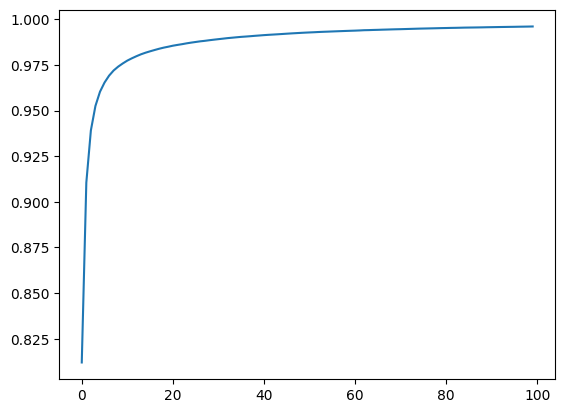

In [86]:
reply_count_df.head(100).reply_count_cumulative.plot()

<AxesSubplot: >

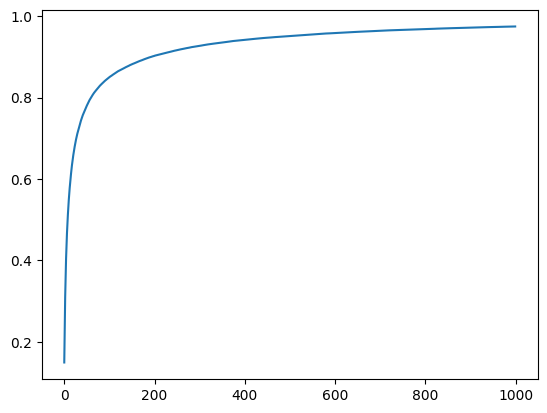

In [84]:
retweet_count_df.head(1000).retweet_count_cumulative.plot()

<AxesSubplot: >

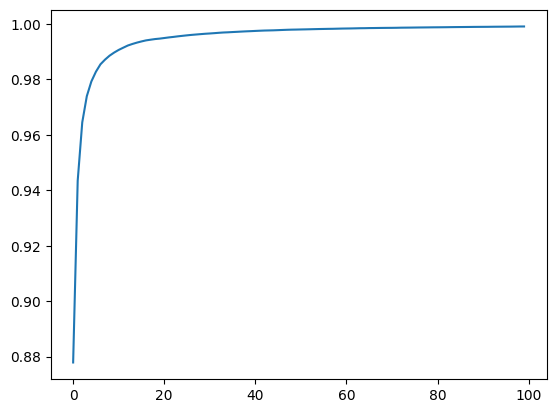

In [80]:
quote_count_df.head(100).quote_count_cumulative.plot()

<AxesSubplot: >

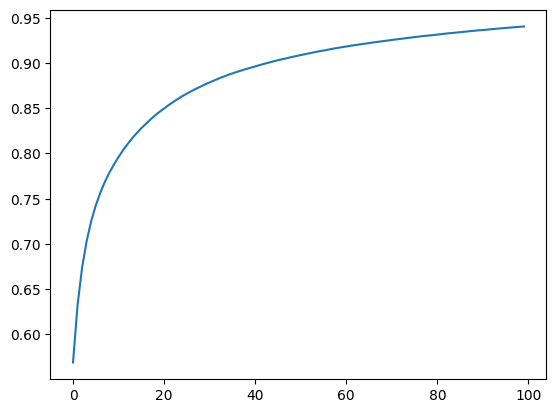

In [68]:
like_counts_df.head(100).like_count_cumulative.plot()

<AxesSubplot: >

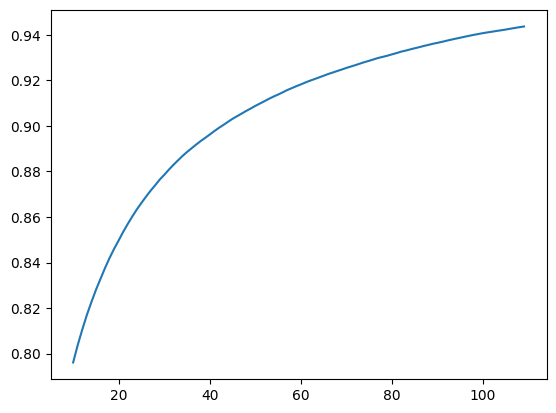

In [105]:
like_counts_df.iloc[10:].head(100).like_count_cumulative.plot()

<AxesSubplot: >

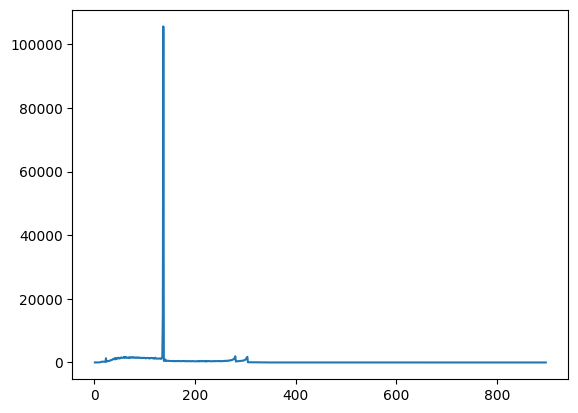

In [ ]:
# Text length
tweets_df_v9.text.apply(lambda x: len(x)).value_counts().sort_index().plot()

In [ ]:
[
    {
        "domain": {
            "id": "131",
            "name": "Unified Twitter Taxonomy",
            "description": "A taxonomy of user interests. ",
        },
        "entity": {
            "id": "847878884917886977",
            "name": "Politics",
            "description": "Politics",
        },
    },
    {
        "domain": {
            "id": "131",
            "name": "Unified Twitter Taxonomy",
            "description": "A taxonomy of user interests. ",
        },
        "entity": {"id": "1046545033657081857", "name": "News", "description": "News"},
    },
]

In [199]:
for i, row in tweets_df[~tweets_df.context_annotations.isna()].reset_index().iterrows():
    if "FOXTV" not in row.text:
        print(row.text)
        print(eval(row.context_annotations))
        if i > 100:
            break

KHKlıHukuk İstiyor https://t.co/mQZhbNhIiJ
[{'domain': {'id': '46', 'name': 'Business Taxonomy', 'description': 'Categories within Brand Verticals that narrow down the scope of Brands'}, 'entity': {'id': '1557696940178935808', 'name': 'Gaming Business', 'description': 'Brands, companies, advertisers and every non-person handle with the profit intent related to offline and online games such as gaming consoles, tabletop games, video game publishers'}}]
#UçurtmayıVurmasınlar https://t.co/HqUUit9p0o
[{'domain': {'id': '46', 'name': 'Business Taxonomy', 'description': 'Categories within Brand Verticals that narrow down the scope of Brands'}, 'entity': {'id': '1557696888568045569', 'name': 'Food & Beverage Business', 'description': 'Brands, companies, advertisers and every non-person handle with the profit intent and related to foods & beverages such as snacks, soft drinks, beers.'}}]
@Sakarya_KHK_54: KHK'lı Platformları Birliği'nin 

hiçbir grup, yapı, kurum, oluşum, siyasi parti, örgüt vb.

# Investigate SSTM topics

In [81]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [4]:
df = pd.read_pickle('all_tweets_v12.pkl')

In [13]:
relevant_topics = [
    'decree-law',
    'search for justice',
    'dismissal of governmental workers',
    'injustice against children',
    'invitation, agenda declaration',
    'expressing wishes',
    'irrelevant tweets',
    'death, torture, suicide',
    'woman rights',
    'politics',
    'democracy',
    'vulnerable, sick people',
    'supreme court',
    'freedom of speech',
    'inflation, financial instability',
    'lost people',
    'internatial relations',
    'Uyghurs in China',
    'activism for nature',
    'too_short_tweet',
]

In [15]:
df['relevant_topic'] = np.where(df['sttm_topic'].isin(relevant_topics), df['sttm_topic'], 'OTHER')

In [35]:
(
    df
    .groupby(['tweet_type', 'relevant_topic'])
    [['like_count', 'retweet_count']]
    .describe()
    .astype(int)
    .style.bar([
        ('like_count','mean'),
        ('retweet_count','mean')
    ])
)

like_count 
 retweet_count 
 
 
   
   
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 tweet_type 
 relevant_topic 
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
 
 
 
 
 quoted 
 OTHER 
 4905 
 33 
 308 
 0 
 1 
 3 
 13 
 17352 
 4905 
 6 
 43 
 0 
 0 
 1 
 3 
 1585 
 
 
 Uyghurs in China 
 800 
 43 
 120 
 0 
 3 
 10 
 26 
 1389 
 800 
 12 
 52 
 0 
 1 
 3 
 8 
 772 
 
 
 activism for nature 
 654 
 80 
 273 
 0 
 3 
 12 
 47 
 4561 
 654 
 17 
 57 
 0 
 0 
 3 
 11 
 944 
 
 
 death, torture, suicide 
 650 
 123 
 343 
 0 
 3 
 17 
 97 
 5319 
 650 
 45 
 139 
 0 
 1 
 5 
 27 
 1950 
 
 
 decree-law 
 5749 
 9 
 75 
 0 
 1 
 2 
 4 
 2611 
 5749 
 2 
 16 
 0 
 0 
 1 
 2 
 1027 
 
 
 democracy 
 1453 
 50 
 205 
 0 
 3 
 11 
 31 
 4772 
 1453 
 9 
 48 
 0 
 1 
 3 
 7 
 1637 
 
 
 dismissal of governmental workers 
 1695 
 8 
 42 
 0 
 1 
 2 
 4 
 1086 
 1695 
 3 
 11 
 0 
 0 
 1 
 3 
 191 
 
 
 expressing wishes 
 2155 
 65 
 328 
 0 
 2 
 7 
 33 
 9721 
 2155 
 8 
 38 
 0 
 0 
 1 
 5 
 822 
 
 
 freedom of speech 
 711 
 74 
 187 
 0 
 5 
 15 
 53 
 1819 
 711 
 17 
 38 
 0 
 2 
 5 
 14 
 329 
 
 
 inflation, financial instability 
 1014 
 136 
 933 
 0 
 3 
 13 
 104 
 28509 
 1014 
 22 
 111 
 0 
 0 
 3 
 17 
 3084 
 
 
 injustice against children 
 2797 
 45 
 263 
 0 
 1 
 2 
 7 
 6628 
 2797 
 11 
 66 
 0 
 0 
 1 
 3 
 1619 
 
 
 internatial relations 
 725 
 50 
 189 
 0 
 2 
 8 
 27 
 2581 
 725 
 9 
 33 
 0 
 1 
 2 
 5 
 576 
 
 
 invitation, agenda declaration 
 991 
 49 
 273 
 0 
 3 
 9 
 28 
 7213 
 991 
 10 
 31 
 0 
 1 
 2 
 7 
 588 
 
 
 irrelevant tweets 
 2744 
 93 
 346 
 0 
 2 
 11 
 52 
 9245 
 2744 
 18 
 62 
 0 
 0 
 2 
 11 
 974 
 
 
 lost people 
 892 
 114 
 399 
 0 
 5 
 21 
 57 
 5867 
 892 
 21 
 79 
 0 
 1 
 4 
 13 
 1124 
 
 
 politics 
 1294 
 116 
 522 
 0 
 2 
 9 
 50 
 13015 
 1294 
 18 
 76 
 0 
 0 
 2 
 9 
 1689 
 
 
 search for justice 
 4248 
 15 
 139 
 0 
 0 
 2 
 4 
 5724 
 4248 
 3 
 25 
 0 
 0 
 1 
 3 
 1153 
 
 
 supreme court 
 1321 
 40 
 180 
 0 
 1 
 4 
 18 
 5018 
 1321 
 13 
 57 
 0 
 0 
 2 
 7 
 1421 
 
 
 too_short_tweet 
 106 
 62 
 228 
 0 
 1 
 2 
 20 
 2121 
 106 
 8 
 36 
 0 
 0 
 1 
 3 
 365 
 
 
 vulnerable, sick people 
 469 
 77 
 235 
 0 
 3 
 10 
 48 
 2944 
 469 
 34 
 123 
 0 
 1 
 2 
 15 
 2178 
 
 
 woman rights 
 1198 
 32 
 121 
 0 
 3 
 8 
 17 
 1945 
 1198 
 8 
 30 
 0 
 1 
 2 
 6 
 592 
 
 
 replied_to 
 OTHER 
 6976 
 6 
 74 
 0 
 0 
 1 
 2 
 4353 
 6976 
 1 
 12 
 0 
 0 
 0 
 1 
 587 
 
 
 Uyghurs in China 
 515 
 65 
 600 
 0 
 1 
 4 
 14 
 13138 
 515 
 10 
 73 
 0 
 0 
 0 
 3 
 1564 
 
 
 activism for nature 
 933 
 42 
 241 
 0 
 1 
 3 
 22 
 5429 
 933 
 8 
 43 
 0 
 0 
 0 
 4 
 714 
 
 
 death, torture, suicide 
 984 
 100 
 450 
 0 
 1 
 9 
 66 
 11344 
 984 
 32 
 87 
 0 
 0 
 3 
 27 
 1518 
 
 
 decree-law 
 6153 
 4 
 97 
 0 
 0 
 1 
 3 
 7469 
 6153 
 1 
 9 
 0 
 0 
 0 
 2 
 631 
 
 
 democracy 
 593 
 53 
 449 
 0 
 2 
 6 
 19 
 7544 
 593 
 7 
 53 
 0 
 0 
 1 
 5 
 897 
 
 
 dismissal of governmental workers 
 3116 
 4 
 46 
 0 
 0 
 1 
 3 
 2263 
 3116 
 1 
 13 
 0 
 0 
 0 
 2 
 514 
 
 
 expressing wishes 
 5299 
 19 
 212 
 0 
 1 
 1 
 4 
 8945 
 5299 
 1 
 21 
 0 
 0 
 0 
 0 
 737 
 
 
 freedom of speech 
 1047 
 21 
 68 
 0 
 1 
 3 
 11 
 915 
 1047 
 6 
 18 
 0 
 0 
 1 
 4 
 249 
 
 
 inflation, financial instability 
 1607 
 50 
 234 
 0 
 1 
 2 
 13 
 4953 
 1607 
 6 
 30 
 0 
 0 
 0 
 1 
 605 
 
 
 injustice against children 
 2396 
 23 
 466 
 0 
 0 
 1 
 3 
 19248 
 2396 
 4 
 55 
 0 
 0 
 0 
 1 
 2321 
 
 
 internatial relations 
 829 
 42 
 301 
 0 
 1 
 5 
 22 
 5813 
 829 
 5 
 39 
 0 
 0 
 0 
 2 
 734 
 
 
 invitation, agenda declaration 
 1774 
 15 
 229 
 0 
 1 
 2 
 6 
 9325 
 1774 
 2 
 23 
 0 
 0 
 0 
 1 
 829 
 
 
 irrelevant tweets 
 5154 
 34 
 279 
 0 
 0 
 2 
 6 
 12141 
 5154 
 4 
 32 
 0 
 0 
 0 
 0 
 1294 
 
 
 lost people 
 1203 
 54 

In [72]:
(
    df
    .query('tweet_type == "standard"')
    .groupby('relevant_topic')
    [['like_count', 'retweet_count']]
    .describe()
    .astype(int)
    .sort_values(('like_count','mean'))
    .style.bar([
        ('like_count','count'),
        ('like_count','mean'),
        ('retweet_count','count')
    ])
)

like_count 
 retweet_count 
 
 
   
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 relevant_topic 
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
 
 
 
 
 dismissal of governmental workers 
 6335 
 35 
 142 
 0 
 3 
 10 
 27 
 4941 
 6335 
 17 
 48 
 0 
 2 
 5 
 16 
 930 
 
 
 decree-law 
 11587 
 41 
 463 
 0 
 3 
 10 
 25 
 29609 
 11587 
 13 
 49 
 0 
 2 
 5 
 14 
 2153 
 
 
 search for justice 
 7768 
 44 
 341 
 0 
 3 
 9 
 23 
 13525 
 7768 
 13 
 53 
 0 
 2 
 5 
 12 
 1702 
 
 
 woman rights 
 4124 
 66 
 500 
 0 
 3 
 8 
 21 
 19270 
 4124 
 12 
 80 
 0 
 1 
 2 
 6 
 3194 
 
 
 injustice against children 
 5954 
 124 
 851 
 0 
 4 
 10 
 32 
 31270 
 5954 
 34 
 152 
 0 
 2 
 6 
 16 
 3664 
 
 
 invitation, agenda declaration 
 3196 
 127 
 690 
 0 
 8 
 30 
 81 
 17843 
 3196 
 28 
 99 
 0 
 2 
 7 
 22 
 2602 
 
 
 internatial relations 
 4132 
 128 
 989 
 0 
 7 
 17 
 41 
 32884 
 4132 
 17 
 104 
 0 
 1 
 3 
 8 
 3477 
 
 
 democracy 
 4271 
 130 
 843 
 0 
 8 
 23 
 64 
 29611 
 4271 
 23 
 113 
 0 
 2 
 6 
 15 
 4736 
 
 
 too_short_tweet 
 56 
 131 
 364 
 0 
 6 
 23 
 46 
 1791 
 56 
 13 
 46 
 0 
 0 
 2 
 6 
 310 
 
 
 Uyghurs in China 
 4314 
 144 
 1300 
 0 
 5 
 14 
 39 
 67204 
 4314 
 39 
 231 
 0 
 1 
 4 
 12 
 6248 
 
 
 OTHER 
 6441 
 157 
 1286 
 0 
 1 
 5 
 22 
 53460 
 6441 
 35 
 201 
 0 
 0 
 2 
 8 
 6762 
 
 
 supreme court 
 2437 
 215 
 1509 
 0 
 6 
 23 
 67 
 57932 
 2437 
 52 
 188 
 0 
 2 
 8 
 28 
 4871 
 
 
 freedom of speech 
 3261 
 247 
 1336 
 0 
 6 
 23 
 101 
 53185 
 3261 
 52 
 201 
 0 
 3 
 7 
 25 
 6704 
 
 
 lost people 
 3541 
 265 
 1107 
 0 
 25 
 71 
 178 
 26391 
 3541 
 63 
 150 
 0 
 5 
 17 
 69 
 3275 
 
 
 vulnerable, sick people 
 3962 
 296 
 936 
 0 
 24 
 130 
 281 
 37869 
 3962 
 197 
 325 
 0 
 9 
 108 
 247 
 4467 
 
 
 activism for nature 
 2142 
 309 
 1497 
 0 
 9 
 29 
 110 
 39091 
 2142 
 56 
 244 
 0 
 2 
 6 
 24 
 4711 
 
 
 expressing wishes 
 4363 
 375 
 2069 
 0 
 7 
 26 
 109 
 57974 
 4363 
 40 
 208 
 0 
 1 
 4 
 14 
 7413 
 
 
 irrelevant tweets 
 3533 
 512 
 1950 
 0 
 10 
 39 
 199 
 39850 
 3533 
 75 
 242 
 0 
 1 
 8 
 35 
 3298 
 
 
 inflation, financial instability 
 3107 
 612 
 2379 
 0 
 8 
 33 
 296 
 73017 
 3107 
 80 
 277 
 0 
 2 
 7 
 44 
 7150 
 
 
 death, torture, suicide 
 3216 
 619 
 1790 
 0 
 19 
 84 
 541 
 38284 
 3216 
 232 
 468 
 0 
 7 
 32 
 243 
 6488 
 
 
 politics 
 3362 
 1024 
 3318 
 0 
 9 
 41 
 559 
 50046 
 3362 
 119 
 367 
 0 
 2 
 8 
 58 
 5263

In [54]:
a = df[
    (df['tweet_type']=='standard') &
    (df['relevant_topic']=='death, torture, suicide')
]['text'].tolist()

In [55]:
a = ' '.join(a)

In [56]:
wordcloud = WordCloud().generate(a)

(-0.5, 399.5, 199.5, -0.5)

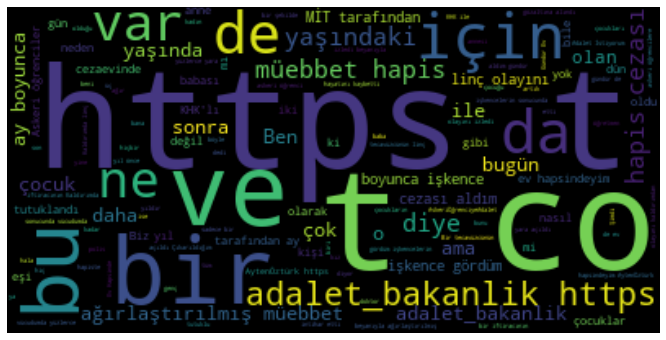

In [58]:
# TO IMPROVE
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# Investigate users' characteristics

In [60]:
df.head(2)

author_id 
 context_annotations 
 conversation_id 
 created_at 
 edit_history_tweet_ids 
 id 
 in_reply_to_user_id 
 lang 
 possibly_sensitive 
 referenced_tweets 
 reply_settings 
 text 
 author 
 withheld 
 geo 
 quote_count 
 retweet_count 
 like_count 
 reply_count 
 impression_count 
 media_keys 
 poll_ids 
 hashtags 
 urls 
 mentions 
 cashtags 
 annotations 
 is_retweet 
 gender_of_author 
 profession_of_author 
 hashtags_flattened 
 trend_topics 
 n_trend_topics 
 text_length 
 has_media 
 has_hashtags 
 has_mentions 
 is_reply 
 tweet_type 
 ratio_like 
 ratio_retweet 
 majority_lang 
 english 
 universal 
 eng_astroturf 
 eng_fake_follower 
 eng_financial 
 eng_other 
 eng_overall 
 eng_self_declared 
 eng_spammer 
 uni_astroturf 
 uni_fake_follower 
 uni_financial 
 uni_other 
 uni_overall 
 uni_self_declared 
 uni_spammer 
 verified_author 
 followers_count_author 
 following_count_author 
 tweet_count_author 
 age_of_account_in_days_author 
 sentiment 
 created_at_day_of_week 
 created_at_month_of_year 
 created_at_time_of_day_in_seconds 
 reply_to_tweet_ratio 
 retweet_to_tweet_ratio 
 average_tweets_of_author_per_day 
 media_media_key_1 
 media_type_1 
 media_height_1 
 media_url_1 
 media_width_1 
 media_public_metrics_1 
 media_preview_image_url_1 
 media_duration_ms_1 
 media_alt_text_1 
 media_media_key_2 
 media_type_2 
 media_height_2 
 media_url_2 
 media_width_2 
 media_public_metrics_2 
 media_preview_image_url_2 
 media_duration_ms_2 
 media_alt_text_2 
 media_media_key_3 
 media_type_3 
 media_height_3 
 media_url_3 
 media_width_3 
 media_public_metrics_3 
 media_preview_image_url_3 
 media_duration_ms_3 
 media_alt_text_3 
 media_media_key_4 
 media_type_4 
 media_height_4 
 media_url_4 
 media_width_4 
 media_public_metrics_4 
 media_preview_image_url_4 
 media_duration_ms_4 
 media_alt_text_4 
 sttm_topic 
 political_context_annotation 
 created_at_year 
 created_at_time_of_day_in_seconds_sin 
 created_at_time_of_day_in_seconds_cos 
 n_media_keys 
 n_hashtags 
 n_urls 
 n_mentions 
 media_resolution_1 
 media_resolution_2 
 media_resolution_3 
 media_resolution_4 
 fear 
 anger 
 anticip 
 trust 
 surprise 
 positive 
 negative 
 sadness 
 disgust 
 joy 
 anticipation 
 translated_tweet 
 age_of_account_in_days_author_when_tweeted 
 posted_during_an_important_event 
 relevant_topic 
 
 
 
 
 0 
 1449804331142811655 
 [] 
 1617597872803041280 
 2023-01-23 18:59:21 
 [1617597872803041280] 
 1617597872803041280 
 NaN 
 tr 
 False 
 NaN 
 everyone 
 Kararlarındaki temel dayanak, hukukun evrensel... 
 Goksun_KHK 
 NaN 
 NaN 
 0 
 2 
 1 
 0 
 82 
 NaN 
 NaN 
 [{'start': 95, 'end': 120, 'tag': 'OhalKomisyo... 
 NaN 
 NaN 
 NaN 
 NaN 
 0 
 ORG 
 NOT AVAILABLE 
 OhalKomisyonuHukuksuzdur 
 OhalKomisyonuHukuksuzdur 
 1 
 120 
 0 
 1 
 0 
 0 
 standard 
 0.012195 
 0.024390 
 tr 
 0.874858 
 0.847463 
 0.13 
 0.51 
 0.22 
 0.91 
 0.91 
 0.08 
 0.25 
 0.12 
 0.44 
 0.1 
 0.87 
 0.87 
 0.19 
 0.16 
 False 
 1107.0 
 174.0 
 2962.0 
 470.0 
 0.994189 
 0 
 1 
 68361 
 0.013817 
 0.435233 
 1.231915 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 search for justice 
 False 
 2023 
 0.976296 
 0.216440 
 0.0 
 1 
 0 
 0 
 NaN 
 NaN 
 NaN 
 NaN 
 0.0 
 0.0 
 0.0 
 1.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 The basic basis in their decisions is the demo... 
 463.0 
 False 
 search for justice 
 
 
 1 
 1449804331142811655 
 [] 
 1617597646339702823 
 2023-01-23 18:58:27 
 [1617597646339702823] 
 1617597646339702823 
 NaN 
 fr 
 False 
 NaN 
 everyone 
 #OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU 
 Goksun_KHK 
 NaN 
 NaN 
 0 
 1 
 0 
 0 
 52 
 [3_1617597636604723228] 
 NaN 
 [{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu... 
 [{'start': 26, 'end': 49, 'url': 'https://t.co... 
 NaN 
 NaN 
 NaN 
 0 
 ORG 
 NOT AVAILABLE 
 OhalKomisyonuHukuks

In [73]:
(
    df
    .query('tweet_type == "standard"')
    .groupby([
        'gender_of_author'
    ])
    [['like_count', 'retweet_count']]
    .describe()
    .astype(int)
    .sort_values(('like_count','mean'))
    .style.bar([
        ('like_count','count'),
        ('like_count','mean'),
        ('retweet_count','mean')
    ])
)

like_count 
 retweet_count 
 
 
   
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 gender_of_author 
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
 
 
 
 
 UNKNOWN 
 67 
 1 
 2 
 0 
 0 
 1 
 2 
 9 
 67 
 0 
 0 
 0 
 0 
 0 
 0 
 2 
 
 
 ORG 
 57052 
 94 
 486 
 0 
 3 
 10 
 32 
 25416 
 57052 
 28 
 100 
 0 
 2 
 5 
 16 
 6248 
 
 
 F 
 11260 
 333 
 1216 
 0 
 17 
 63 
 244 
 57974 
 11260 
 105 
 288 
 0 
 2 
 10 
 46 
 4326 
 
 
 M 
 22723 
 482 
 2377 
 0 
 10 
 31 
 110 
 73017 
 22723 
 76 
 309 
 0 
 2 
 6 
 20 
 7413

In [75]:
(
    df
    .query('tweet_type == "standard"')
    .groupby([
        'profession_of_author'
    ])
    [['like_count', 'retweet_count']]
    .describe()
    .astype(int)
    .sort_values(('like_count','mean'))
    .style.bar([
        ('like_count','count'),
        ('like_count','mean'),
        ('retweet_count','mean')
    ])
)

like_count 
 retweet_count 
 
 
   
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 profession_of_author 
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
 
 
 
 
 WRITER 
 2075 
 68 
 132 
 0 
 16 
 41 
 76 
 3421 
 2075 
 9 
 30 
 0 
 1 
 4 
 9 
 593 
 
 
 NOT AVAILABLE 
 57052 
 94 
 486 
 0 
 3 
 10 
 32 
 25416 
 57052 
 28 
 100 
 0 
 2 
 5 
 16 
 6248 
 
 
 ACADEMICIAN 
 1259 
 142 
 623 
 0 
 2 
 19 
 93 
 19270 
 1259 
 24 
 80 
 0 
 0 
 3 
 24 
 2220 
 
 
 JOURNALIST 
 9698 
 173 
 450 
 0 
 6 
 18 
 76 
 6519 
 9698 
 92 
 285 
 0 
 1 
 3 
 14 
 4326 
 
 
 DOCTOR 
 597 
 205 
 1068 
 0 
 16 
 36 
 79 
 20634 
 597 
 24 
 126 
 0 
 0 
 2 
 7 
 2333 
 
 
 UNKNOWN 
 7039 
 325 
 906 
 0 
 10 
 57 
 213 
 17848 
 7039 
 60 
 191 
 0 
 2 
 11 
 39 
 4123 
 
 
 POLITICIAN 
 8851 
 491 
 2759 
 0 
 25 
 50 
 115 
 57932 
 8851 
 69 
 298 
 0 
 5 
 10 
 22 
 6704 
 
 
 ARTIST 
 394 
 708 
 1131 
 20 
 146 
 359 
 812 
 9404 
 394 
 79 
 263 
 0 
 7 
 21 
 69 
 4467 
 
 
 TEACHER 
 767 
 1120 
 3729 
 0 
 6 
 234 
 650 
 57974 
 767 
 108 
 310 
 0 
 3 
 21 
 82 
 3298 
 
 
 LAWYER 
 3028 
 1350 
 3885 
 0 
 10 
 42 
 804 
 73017 
 3028 
 208 
 532 
 0 
 1 
 8 
 183 
 7413 
 
 
 BASKETBALL PLAYER 
 342 
 2139 
 4529 
 107 
 592 
 983 
 1893 
 53460 
 342 
 503 
 702 
 21 
 160 
 279 
 563 
 6762

In [74]:
(
    df
    .query('tweet_type == "standard"')
    .groupby([
        'verified_author'
    ])
    [['like_count', 'retweet_count']]
    .describe()
    .astype(int)
    .sort_values(('like_count','mean'))
    .style.bar([
        ('like_count','count'),
        ('like_count','mean'),
        ('retweet_count','mean')
    ])
)

like_count 
 retweet_count 
 
 
   
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 verified_author 
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
 
 
 
 
 False 
 79847 
 180 
 970 
 0 
 4 
 14 
 54 
 73017 
 79847 
 46 
 182 
 0 
 1 
 5 
 19 
 7413 
 
 
 True 
 11255 
 502 
 2747 
 0 
 15 
 38 
 103 
 57974 
 11255 
 74 
 310 
 0 
 3 
 8 
 20 
 6762

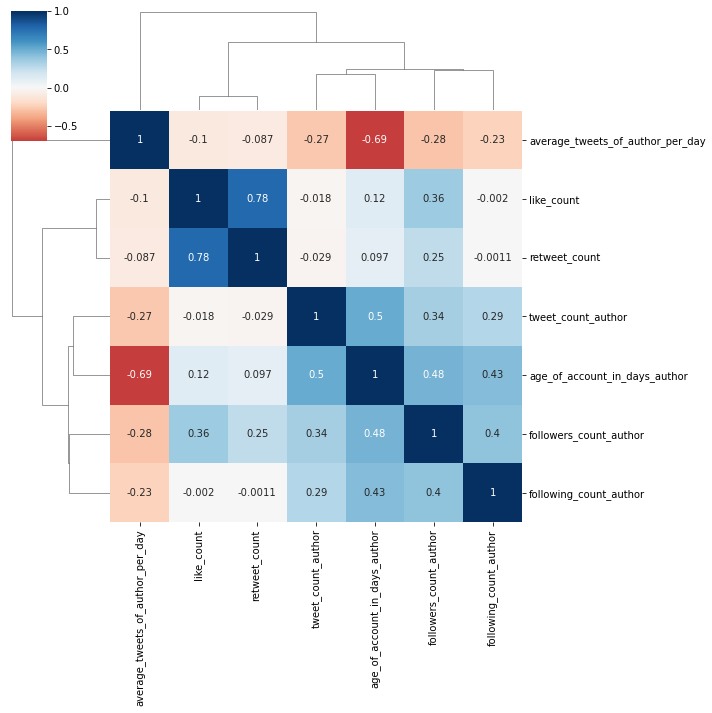

In [85]:
sns.clustermap(
    df
    .query('tweet_type == "standard"')
    [[
        'like_count', 
        'retweet_count',
        'followers_count_author',
        'following_count_author',
        'tweet_count_author',
        'age_of_account_in_days_author',
        'average_tweets_of_author_per_day'
    ]]
    .corr(),
    annot=True, cmap='RdBu', center=0
);

# Investigate emotions

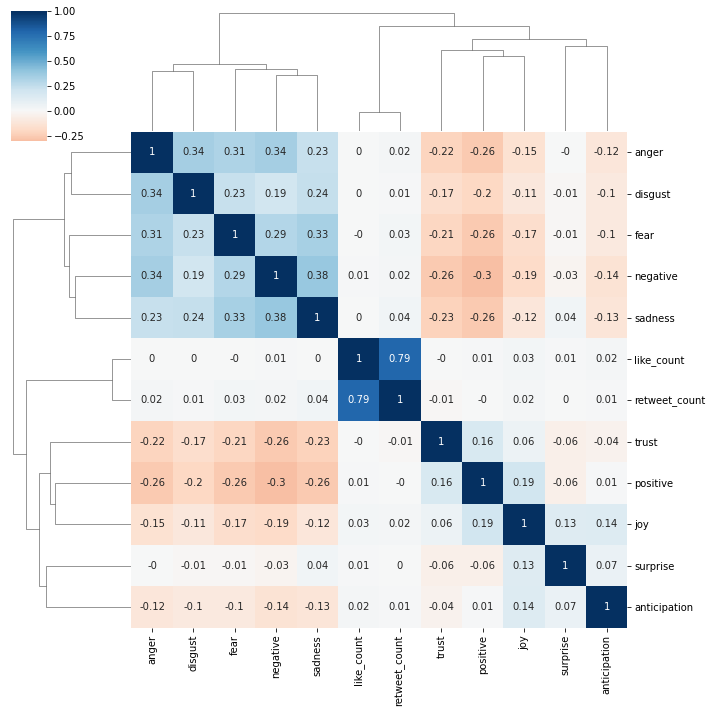

In [116]:
sns.clustermap(
    df
    [[
        'like_count', 
        'retweet_count',
        'fear',
        'anger',
        'trust',
        'surprise',
        'positive',
        'negative',
        'sadness',
        'disgust',
        'joy',
        'anticipation'
    ]]
    .dropna()
    .corr()
    .round(2)
    ,
    annot=True, cmap='RdBu', center=0
);